In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

In [2]:
# getting our dataset
df =              yf.download('AAPL')
df =              df.reset_index()
df['tmrw_close'] =      df['Close'].shift(-1) 

# getting the last 2 years of data. counting leap day because why not man
numberToGetLastTwoYears = len(df) - 731
df =              df.iloc[numberToGetLastTwoYears:].copy()

# rearranging the columns becuase I was kind of annoyed by the way yfinance gives it to us lol
cols =            df.columns.tolist()
cols =            cols[4:5] + cols[:4]    + cols[5:]
df =              df[cols]

# dropping the date because we don't need it and i forgot to do it earlier
df = df.drop(['Date'], axis=1)

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
df['tmrw_close'] =      df['tmrw_close'].fillna(method='ffill', limit=2)
data = df
data

[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,Adj Close,Volume,tmrw_close
9915,66.997498,67.175003,67.517502,66.175003,65.691422,161834800,68.312500
9916,68.312500,67.077499,68.425003,66.457497,66.980774,131022800,71.762497
9917,71.762497,70.000000,72.062500,69.512497,70.363533,194994800,71.107498
9918,71.107498,70.599998,71.582497,70.157501,69.721291,131154400,71.672501
9919,71.672501,71.845001,72.050003,70.587502,70.275284,157125200,70.699997
...,...,...,...,...,...,...,...
10641,147.410004,147.050003,149.080002,146.830002,147.410004,50547000,145.309998
10642,145.309998,146.830002,147.229996,145.009995,145.309998,55479000,145.910004
10643,145.910004,144.380005,146.710007,143.899994,145.910004,52238100,151.029999
10644,151.029999,148.039993,151.110001,147.330002,151.029999,70668500,153.830002


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (584, 7) trainY: (584,)
testX: (147, 7) testY: (147,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [5]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([7, 400, 400, 400, 10], 10)

[1/300] Loss: 151.6809902191162
[2/300] Loss: 145.89179229736328
[3/300] Loss: 140.52511596679688
[4/300] Loss: 135.86841011047363
[5/300] Loss: 131.2401361465454
[6/300] Loss: 126.35901546478271
[7/300] Loss: 121.34938621520996
[8/300] Loss: 116.44001197814941
[9/300] Loss: 111.85601711273193
[10/300] Loss: 107.9489221572876
[11/300] Loss: 105.09928131103516
[12/300] Loss: 103.61315155029297
[13/300] Loss: 103.72850131988525
[14/300] Loss: 105.4914379119873
[15/300] Loss: 108.54601192474365
[16/300] Loss: 112.17923164367676
[17/300] Loss: 115.45893001556396
[18/300] Loss: 117.52706336975098
[19/300] Loss: 117.80932235717773
[20/300] Loss: 116.17477893829346
[21/300] Loss: 112.97807884216309
[22/300] Loss: 108.90978622436523
[23/300] Loss: 104.67020893096924
[24/300] Loss: 100.9511604309082
[25/300] Loss: 98.19004249572754
[26/300] Loss: 96.52787399291992
[27/300] Loss: 95.9152307510376
[28/300] Loss: 96.11098098754883
[29/300] Loss: 96.89351749420166
[30/300] Loss: 97.9944372177124
[3

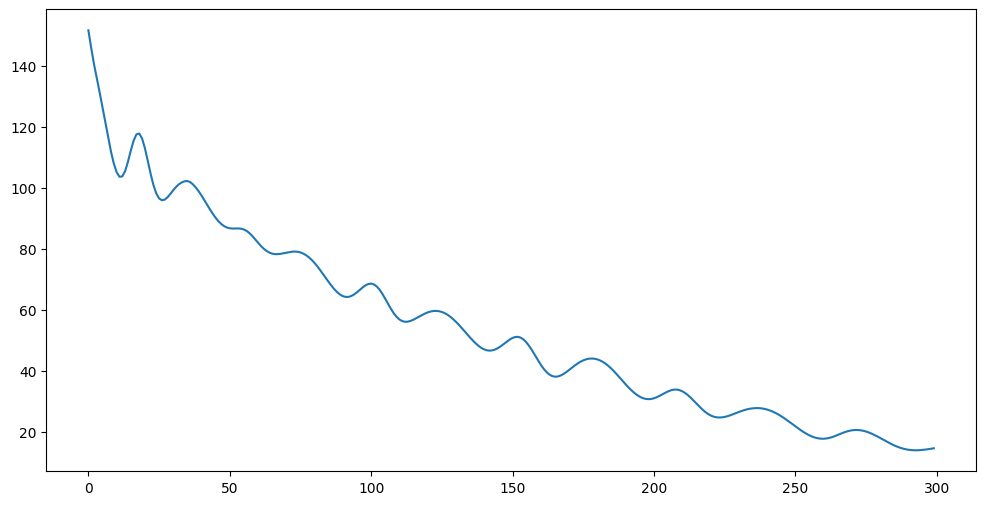

In [6]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300 #ORIGINALLY 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [7]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([581, 3, 17]) train_y: torch.Size([581, 1]) train_y_gan: torch.Size([581, 4, 1])
test_x: torch.Size([144, 3, 17]) test_y: torch.Size([144, 1]) test_y_gan: torch.Size([144, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [12]:
# imports
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml


#create a classical lstm model
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out
#defines all the methods to be used in QuantumShallowRegressionLSTM
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        #self.dev_forget = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_input = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_update = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_output = qml.device(self.backend, wires=self.n_qubits)
        
        def ansatz(params, wires_type):
            # Entangling layer.
            for i in range(1,3): 
                for j in range(self.n_qubits):
                    if j + i < self.n_qubits:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i]])
                    else:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i - self.n_qubits]])

            # Variational layer.
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=wires_type[i])
                qml.RY(params[1][i], wires=wires_type[i])
                qml.RZ(params[2][i], wires=wires_type[i])
                
        def VQC(features, weights, wires_type):
            # Preproccess input data to encode the initial state.
            #qml.templates.AngleEmbedding(features, wires=wires_type)
            ry_params = [torch.arctan(feature) for feature in features]
            rz_params = [torch.arctan(feature**2) for feature in features]
            for i in range(self.n_qubits):
                qml.Hadamard(wires=wires_type[i])
                qml.RY(ry_params[i], wires=wires_type[i])
                qml.RZ(ry_params[i], wires=wires_type[i])
        
            #Variational block.
            qml.layer(ansatz, self.n_qlayers, weights, wires_type = wires_type)

        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations, self.n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_vrotations, n_qubits) = ({self.n_qlayers}, {self.n_vrotations}, {self.n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)
    
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        #self.lstm = nn.LSTM(
        #    input_size=num_sensors,
        #    hidden_size=hidden_units,
        #    batch_first=True,
        #    num_layers=self.num_layers
        #)
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [13]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 12 #128 
learning_rate = 0.004
num_epochs = 35 #ORIGINALLY 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

#modelG = Generator(17).to(device)
modelG = QShallowRegressionLSTM(num_sensors=17, hidden_units= 16, n_qubits=4)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)
[1/35] LossD: 68.08341562747955 LossG:34.112324833869934
[2/35] LossD: 70.48895567655563 LossG:41.20949681196362
[3/35] LossD: 357.98360680788755 LossG:46.21170412371673
[4/35] LossD: 66.6068882420659 LossG:53.37191218137741
[5/35] LossD: 62.7167809009552 LossG:45.38022693991661
[6/35] LossD: 66.74890040233731 LossG:64.63583815097809
[7/35] LossD: 64.62160743772984 LossG:66.4284939467907
[8/35] LossD: 63.855074144899845 LossG:63.26715776324272
[9/35] LossD: 63.44466004520655 LossG:58.01626294851303
[10/35] LossD: 67.276321740821 LossG:67.19440910220146
[11/35] LossD: 67.40389919281006 LossG:44.89773517847061
[12/35] LossD: 66.74091225862503 LossG:47.33674520254135
[13/35] LossD: 69.18109881877899 LossG:52.54804748296738
[14/35] LossD: 67.24726402759552 LossG:44.54484838247299
[15/35] LossD: 69.12449616193771 LossG:41.866975113749504
[16/35] LossD: 66.8964803814888 LossG:56.08548206090927
[17/35] LossD: 68.31932961940765 Lo

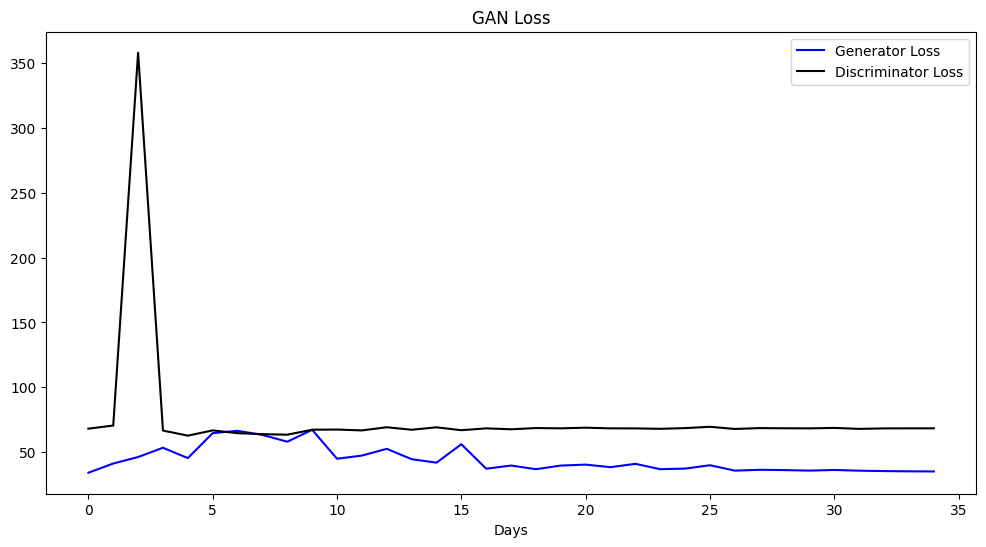

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [15]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
y_train_true = y_scaler.inverse_transform(train_y_slide)
# higgitydiggitydo = pred_y_train.cpu().detach.numpy()
print(pred_y_test)

tensor([[0.8845],
        [0.8479],
        [0.9045],
        [0.9138],
        [0.9390],
        [0.9461],
        [0.9510],
        [0.9255],
        [0.9188],
        [0.9279],
        [0.8774],
        [0.8853],
        [0.8788],
        [0.9196],
        [0.8530],
        [0.8251],
        [0.8036],
        [0.7761],
        [0.7636],
        [0.8008],
        [0.7672],
        [0.7561],
        [0.7508],
        [0.7995],
        [0.8118],
        [0.7263],
        [0.7562],
        [0.7235],
        [0.6422],
        [0.7335],
        [0.7341],
        [0.7376],
        [0.7277],
        [0.6766],
        [0.7108],
        [0.7072],
        [0.6312],
        [0.6111],
        [0.5903],
        [0.6164],
        [0.6512],
        [0.6535],
        [0.6734],
        [0.6267],
        [0.6475],
        [0.5997],
        [0.5804],
        [0.5963],
        [0.6007],
        [0.6211],
        [0.6639],
        [0.6649],
        [0.6570],
        [0.6561],
        [0.7114],
        [0

In [16]:
pred_y_test = pred_y_test.reshape(-1, 1)
print(pred_y_test)

tensor([[0.8845],
        [0.8479],
        [0.9045],
        [0.9138],
        [0.9390],
        [0.9461],
        [0.9510],
        [0.9255],
        [0.9188],
        [0.9279],
        [0.8774],
        [0.8853],
        [0.8788],
        [0.9196],
        [0.8530],
        [0.8251],
        [0.8036],
        [0.7761],
        [0.7636],
        [0.8008],
        [0.7672],
        [0.7561],
        [0.7508],
        [0.7995],
        [0.8118],
        [0.7263],
        [0.7562],
        [0.7235],
        [0.6422],
        [0.7335],
        [0.7341],
        [0.7376],
        [0.7277],
        [0.6766],
        [0.7108],
        [0.7072],
        [0.6312],
        [0.6111],
        [0.5903],
        [0.6164],
        [0.6512],
        [0.6535],
        [0.6734],
        [0.6267],
        [0.6475],
        [0.5997],
        [0.5804],
        [0.5963],
        [0.6007],
        [0.6211],
        [0.6639],
        [0.6649],
        [0.6570],
        [0.6561],
        [0.7114],
        [0

In [17]:
y_train_pred = (y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy()))
y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:5.002840653105877


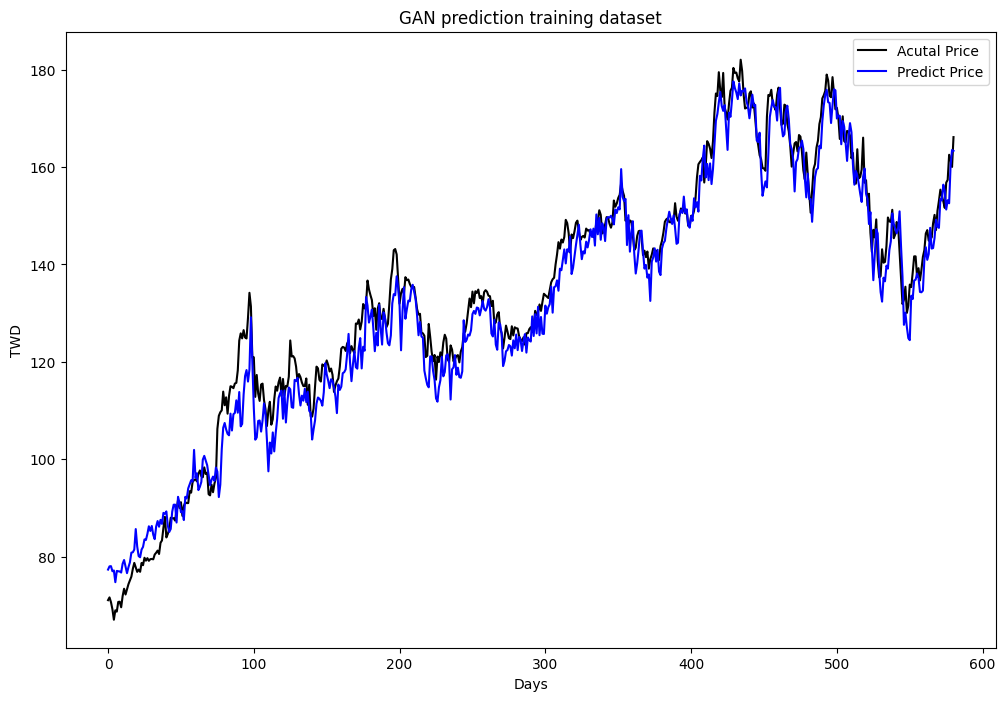

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:4.11504693374528


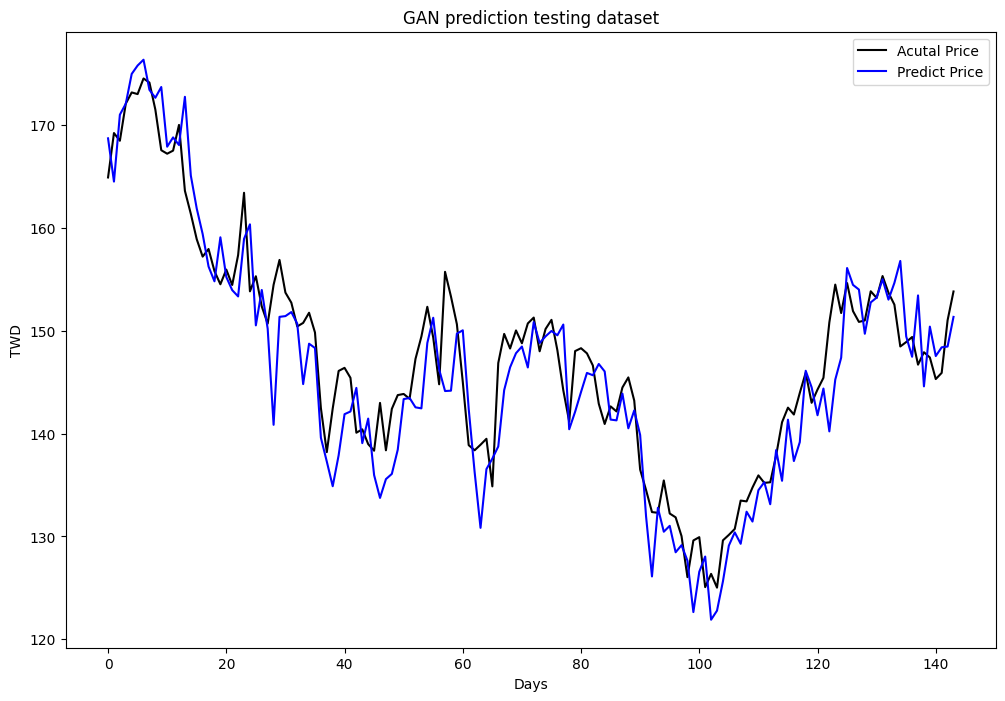

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')